In [1]:
## Set Python - Spark environment.
import os
import sys
os.environ["SPARK_HOME"] = "/usr/hdp/current/spark2-client"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.6-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [2]:
## Create SparkContext, SparkSession
from os.path import expanduser, join, abspath

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Row

# warehouse_location points to the default location for managed databases and tables
warehouse_location = 'hdfs:///apps/hive/warehouse/'

spark = SparkSession \
    .builder \
    .appName("Python_Spark_PHD_Complete") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
spark

## There are two problem statements in the PHD paper.
#### <font color='brown'> Submission file: </font>
Submission file should be a ipynb file with name: 20190202_CSE7322c_Batch48_PHD_EnrolliD.ipynb 

#### Dataset Information 

The data set is at 10 min for about 4.5 months. The house temperature and humidity
conditions were monitored with a wireless sensor network. Each wireless node
transmitted the temperature and humidity conditions around 3.3 min. Then, the
wireless data was averaged for 10 minutes periods. The energy data was logged
every 10 minutes with m-bus energy meters.
The data is available in the RDBMS and need to be ingested into HDFS.

**Problem Statement**: Using the data described below, we need to build predictive models for energy use of appliances. Data used include measurements of temperature and humidity sensors from a wireless network, weather from a nearby weather station and recorded energy use of lighting fixtures

#### Dataset variables information : 

**date**,  year-month-day hour:minute:second <br/>
**Appliances**, energy use in Wh <br/>
**lights**, energy use of light fixtures in the house in Wh <br/>
**T1**, Temperature in kitchen area, in Celsius <br/>
**RH_1**, Humidity in kitchen area, in % <br/>
**T2**, Temperature in living room area, in Celsius <br/> 
**RH_2**, Humidity in living room area, in % <br/>
**T3**, Temperature in laundry room area <br/>
**RH_3**, Humidity in laundry room area, in % <br/>
**T4**, Temperature in office room, in Celsius <br/>
**RH_4**, Humidity in office room, in % <br/>
**T5**, Temperature in bathroom, in Celsius <br/>
**RH_5**, Humidity in bathroom, in % <br/>
**T6**, Temperature outside the building (north side), in Celsius <br/>
**RH_6**, Humidity outside the building (north side), in % <br/>
**T7**, Temperature in ironing room , in Celsius <br/>
**RH_7**, Humidity in ironing room, in % <br/>
**T8**, Temperature in teenager room 2, in Celsius <br/>
**RH_8**, Humidity in teenager room 2, in % <br/>
**T9**, Temperature in parents room, in Celsius <br/>
**RH_9**, Humidity in parents room, in % <br/>
**To**, Temperature outside (otained from weather station), in Celsius <br/>
**Press_mm_hg** (Obtained from weather station), in mm Hg <br/>
**RH_out**, Humidity outside (Obtained from weather station), in % <br/>
**Wind speed** (obtained from weather station), in m/s <br/>
**Visibility** (obtained from weather station), in km <br/>
**Tdewpoint** (obtianed from weather station), °C <br/>
**rv1**, Random variable 1, nondimensional <br/>
**rv2**, Random variable 2, nondimensional <br/>
**nsm**, Number of seconds from MidNight <br/>
**weekstatus**, weekend or workday<br/>
**Day_of_week**, Day of the week<br/>

### **Data Ingestion** - Ingest the data into HDFS from mysql database using Sqoop 
**Database Name**  - insofe_b48_energyDB <br/>
**Table Name (Train)** - energy_traindb_data (Training Dataset)<br/>
**Table Name (Test)** - energy_testdb_data (Testing Dataset)<br/>

In [ ]:
### Insert the sqoop command in the below cells

In [ ]:
sqoop job --create initial -- import-all-tables --connect jdbc:mysql://172.16.0.226:3306/insofe_b48_energyDB --username insofeadmin --
password insofe_password --warehouse-dir '/user/2306B48/phd/data' -m 1

In [ ]:
sqoop job --exec initial

### Data Preprocessing 
Note - Only Pyspark dataframe API/SQL API need to be used to process the data. 
**Using pyspark only** , Construct the schema for the dataset. Read the csv file from hdfs as a spark dataframe.Read the dataset as a dataframe with the specified data types  Check for null values using pyspark Dataframe and perform basic preprocessing.

In [4]:
data = sc.textFile("hdfs:///user/2306B48/phd/data/energy_traindb_data*")

In [5]:
test = sc.textFile("hdfs:///user/2306B48/phd/data/energy_testdb_data*")

In [6]:
print("Total Records with header: ", data.count()) # Checking total count

('Total Records with header: ', 14803)


In [7]:
data.take(1)

[u'2016-01-11 17:00:00.0,60,30,19.8900000000000010000000000,47.5966666666667000000000000,19.1999999999999990000000000,44.7899999999999990000000000,19.7899999999999990000000000,44.7299999999999970000000000,19.0000000000000000000000000,45.5666666666666980000000000,17.1666666666667000000000000,55.2000000000000030000000000,7.0266666666666699470000000,84.2566666666667032000000000,17.1999999999999990000000000,41.6266666666667010000000000,18.1999999999999990000000000,48.8999999999999990000000000,17.0333333333332990000000000,45.5300000000000010000000000,6.5999999999999996000000000,733.5000000000000000000000000,92.0000000000000000000000000,7.0000000000000000000000000,63.0000000000000000000000000,5.2999999999999998000000000,13.2754331571049988270000000,13.2754331571049988270000000,61200,Weekday,Monday']

In [8]:
from pyspark.sql.types import *

In [9]:
schema = StructType([
    StructField("date", StringType(), True),
    StructField("Appliances", IntegerType() , True),
    StructField("lights", IntegerType(), True),
    StructField("T1", DoubleType(), True),
    StructField("RH_1", DoubleType(), True),
    StructField("T2", DoubleType(), True),
    StructField("RH_2", DoubleType(), True),
    StructField("T3", DoubleType(), True),
    StructField("RH_3", DoubleType(), True),
    StructField("T4", DoubleType(), True),
    StructField("RH_4", DoubleType(), True),
    StructField("T5", DoubleType(), True),
    StructField("RH_5", DoubleType(), True),
    StructField("T6", DoubleType(), True),
    StructField("RH_6", DoubleType(), True),
    StructField("T7", DoubleType(), True),
    StructField("RH_7", DoubleType(), True),
    StructField("T8", DoubleType(), True),
    StructField("RH_8", DoubleType(), True),
    StructField("T9", DoubleType(), True),
    StructField("RH_9", DoubleType(), True),
    StructField("To", DoubleType(), True),
    StructField("Press_mm_hg", DoubleType(), True),
    StructField("RH_out", DoubleType(), True),
    StructField("Wind speed", DoubleType(), True),
    StructField("Visibility", DoubleType(), True),
    StructField("Tdewpoint", DoubleType(), True),
    StructField("rv1", DoubleType(), True),
    StructField("rv2", DoubleType(), True),
    StructField("nsm", IntegerType(), True),
    StructField("weekstatus", StringType(), True),
    StructField("Day_of_week", StringType(), True),
])

In [10]:
testschema = StructType([
    StructField("date", StringType(), True),
    StructField("lights", IntegerType(), True),
    StructField("T1", DoubleType(), True),
    StructField("RH_1", DoubleType(), True),
    StructField("T2", DoubleType(), True),
    StructField("RH_2", DoubleType(), True),
    StructField("T3", DoubleType(), True),
    StructField("RH_3", DoubleType(), True),
    StructField("T4", DoubleType(), True),
    StructField("RH_4", DoubleType(), True),
    StructField("T5", DoubleType(), True),
    StructField("RH_5", DoubleType(), True),
    StructField("T6", DoubleType(), True),
    StructField("RH_6", DoubleType(), True),
    StructField("T7", DoubleType(), True),
    StructField("RH_7", DoubleType(), True),
    StructField("T8", DoubleType(), True),
    StructField("RH_8", DoubleType(), True),
    StructField("T9", DoubleType(), True),
    StructField("RH_9", DoubleType(), True),
    StructField("To", DoubleType(), True),
    StructField("Press_mm_hg", DoubleType(), True),
    StructField("RH_out", DoubleType(), True),
    StructField("Wind speed", DoubleType(), True),
    StructField("Visibility", DoubleType(), True),
    StructField("Tdewpoint", DoubleType(), True),
    StructField("rv1", DoubleType(), True),
    StructField("rv2", DoubleType(), True),
    StructField("nsm", IntegerType(), True),
    StructField("weekstatus", StringType(), True),
    StructField("Day_of_week", StringType(), True),
])

In [11]:
energyDF = spark.read.format("csv")\
        .option("header", "false")\
        .option("inferSchema", "true")\
        .load("hdfs:///user/2306B48/phd/data/energy_traindb_data*",schema = schema)

In [12]:
testDF = spark.read.format("csv")\
        .option("header", "false")\
        .option("inferSchema", "true")\
        .load("hdfs:///user/2306B48/phd/data/energy_testdb_data*",schema = testschema)

In [13]:
energyDF.show(5)

+--------------------+----------+------+-----+----------------+----+----------------+-----+----------------+----------------+----------------+----------------+-----+----------------+----------------+----------------+----------------+----+----------------+----------------+-----+----------------+-----------+------+----------------+----------------+---------+------------------+------------------+-----+----------+-----------+
|                date|Appliances|lights|   T1|            RH_1|  T2|            RH_2|   T3|            RH_3|              T4|            RH_4|              T5| RH_5|              T6|            RH_6|              T7|            RH_7|  T8|            RH_8|              T9| RH_9|              To|Press_mm_hg|RH_out|      Wind speed|      Visibility|Tdewpoint|               rv1|               rv2|  nsm|weekstatus|Day_of_week|
+--------------------+----------+------+-----+----------------+----+----------------+-----+----------------+----------------+----------------+------

In [14]:
print("Total Records with header: ", energyDF.count())

('Total Records with header: ', 14803)


In [15]:
energyDF.dtypes

[('date', 'string'),
 ('Appliances', 'int'),
 ('lights', 'int'),
 ('T1', 'double'),
 ('RH_1', 'double'),
 ('T2', 'double'),
 ('RH_2', 'double'),
 ('T3', 'double'),
 ('RH_3', 'double'),
 ('T4', 'double'),
 ('RH_4', 'double'),
 ('T5', 'double'),
 ('RH_5', 'double'),
 ('T6', 'double'),
 ('RH_6', 'double'),
 ('T7', 'double'),
 ('RH_7', 'double'),
 ('T8', 'double'),
 ('RH_8', 'double'),
 ('T9', 'double'),
 ('RH_9', 'double'),
 ('To', 'double'),
 ('Press_mm_hg', 'double'),
 ('RH_out', 'double'),
 ('Wind speed', 'double'),
 ('Visibility', 'double'),
 ('Tdewpoint', 'double'),
 ('rv1', 'double'),
 ('rv2', 'double'),
 ('nsm', 'int'),
 ('weekstatus', 'string'),
 ('Day_of_week', 'string')]

In [16]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
print("Total Columns count in  sales dataset is {}".format(len(energyDF.columns)))

Total Columns count in  sales dataset is 32


In [17]:
energyDF.describe().show() # Descriptive Stats

+-------+--------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+--------------------+--------------------+------------------+----------+-----------+
|summary|                date|       Appliances|           lights|                T1|              RH_1|               T2|             RH_2|                T3|              RH_3|                T4|             RH_4|               T5|             RH_5|               T6|              RH_6|                T7|              RH_7|                T8|             RH_8|                T9|              RH_9| 

In [18]:
energyDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in energyDF.columns]).show() # check Null

+----+----------+------+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+-----------+------+----------+----------+---------+---+---+---+----------+-----------+
|date|Appliances|lights| T1|RH_1| T2|RH_2| T3|RH_3| T4|RH_4| T5|RH_5| T6|RH_6| T7|RH_7| T8|RH_8| T9|RH_9| To|Press_mm_hg|RH_out|Wind speed|Visibility|Tdewpoint|rv1|rv2|nsm|weekstatus|Day_of_week|
+----+----------+------+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+-----------+------+----------+----------+---------+---+---+---+----------+-----------+
|   0|         0|     0|  0|   0|  0|   0|  0|   0|  0|   0|  0|   0|  0|   0|  0|   0|  0|   0|  0|   0|  0|          0|     0|         0|         0|        0|  0|  0|  0|         0|          0|
+----+----------+------+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+----+---+-----------+------+----------+----------+---------+---+---+---+----------+-----------+



In [19]:
energyDF.agg(*(countDistinct(col(c)).alias(c) for c in energyDF.columns)).show() # distinct

+-----+----------+------+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+-----------+------+----------+----------+---------+-----+-----+---+----------+-----------+
| date|Appliances|lights| T1|RH_1|  T2|RH_2|  T3|RH_3|  T4|RH_4|  T5|RH_5|  T6|RH_6|  T7|RH_7|  T8|RH_8| T9|RH_9|  To|Press_mm_hg|RH_out|Wind speed|Visibility|Tdewpoint|  rv1|  rv2|nsm|weekstatus|Day_of_week|
+-----+----------+------+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+-----------+------+----------+----------+---------+-----+-----+---+----------+-----------+
|14803|        88|     6|630|2235|1379|2883|1227|2218|1184|2559|1926|6129|3738|8062|1693|4865|1941|5488|824|2857|1689|       2050|   515|       162|       387|     1347|14803|14803|144|         2|          7|
+-----+----------+------+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+-----------+------+----------+----------+-----

In [20]:
energyDF.agg(*(min(col(c)).alias(c) for c in energyDF.columns)).show() # min values

+--------------------+----------+------+-----+----------------+----+----------------+----+----------------+----+-----+-----+----------------+------+----+-----+----+----------------+----+-----+----------------+-----------------+-----------+------+----------+----------+-----------------+--------------------+--------------------+---+----------+-----------+
|                date|Appliances|lights|   T1|            RH_1|  T2|            RH_2|  T3|            RH_3|  T4| RH_4|   T5|            RH_5|    T6|RH_6|   T7|RH_7|              T8|RH_8|   T9|            RH_9|               To|Press_mm_hg|RH_out|Wind speed|Visibility|        Tdewpoint|                 rv1|                 rv2|nsm|weekstatus|Day_of_week|
+--------------------+----------+------+-----+----------------+----+----------------+----+----------------+----+-----+-----+----------------+------+----+-----+----+----------------+----+-----+----------------+-----------------+-----------+------+----------+----------+-----------------+--

In [21]:
energyDF.agg(*(max(col(c)).alias(c) for c in energyDF.columns)).show() # max values

+--------------------+----------+------+-----+-----+----------------+----------------+------+----------------+----+----------------+------+----------------+-----+----+----+----+-----+-----+----+----------------+----+-----------+------+----------+----------+---------+----------------+----------------+-----+----------+-----------+
|                date|Appliances|lights|   T1| RH_1|              T2|            RH_2|    T3|            RH_3|  T4|            RH_4|    T5|            RH_5|   T6|RH_6|  T7|RH_7|   T8| RH_8|  T9|            RH_9|  To|Press_mm_hg|RH_out|Wind speed|Visibility|Tdewpoint|             rv1|             rv2|  nsm|weekstatus|Day_of_week|
+--------------------+----------+------+-----+-----+----------------+----------------+------+----------------+----+----------------+------+----------------+-----+----+----+----+-----+-----+----+----------------+----+-----------+------+----------+----------+---------+----------------+----------------+-----+----------+-----------+
|2016-0

In [22]:
energyDF = energyDF.drop('rv1','rv2')

In [23]:
testDF =testDF.drop('rv1','rv2')

### Exploratory analysis
Build some basic plots (bar graph, heat map) using python (pandas , matplotlib/seaborn/ploytly) by converting the spark dataframe to pandas df.

In [24]:
import numpy as np
import StringIO
import pandas as pd
import warnings

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
plotly.tools.set_credentials_file(username='aashutosh.bhattad', api_key='dfQ17QdEz3ZZifx2MpbX')

import plotly.figure_factory as ff
import plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

# Initializing some settings
sns.set_style('whitegrid')
sns.set(color_codes=True)
warnings.filterwarnings('ignore')
pyoff.init_notebook_mode(connected=True)
get_ipython().magic('matplotlib inline')

In [26]:
pandasDF = energyDF.toPandas()
pandasDF.columns = ['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2','T3', 'RH_3', 'T4', 'RH_4', 'T5',
                    'RH_5', 'T6', 'RH_6',"T7","RH_7","T8","RH_8","T9","RH_9","To","Press_mm_hg","RH_out",
                    "Wind speed","Visibility","Tdewpoint","nsm","weekstatus","Day_of_week"]
trace1 = go.Histogram(
    x=pandasDF['date'],
    y=pandasDF['Appliances'],
    name='date and Appliances ',
      marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
#using plotly
data = [trace1]
layout = go.Layout(
    title='date vs Appliances',
    
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot1')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~aashutosh.bhattad/0 or inside your plot.ly account where it is named 'plot1'


In [27]:
trace3 = go.Histogram(
    x=pandasDF['Day_of_week'],
    y=pandasDF['Appliances'],
    name='day and Appliances ',
      marker = dict(
        color = 'rgb(200, 128, 128)',
    )
)
#using plotly
data = [trace3]
layout = go.Layout(
    title='day vs Appliances',
    
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='dapp')

In [28]:
trace2 = go.Box(
    x=pandasDF['lights'],
    y=pandasDF['Appliances'],
    name='Appliances and lights',
      marker = dict(
        color = 'rgb(128, 0, 0)',
    )
)
#using plotly
data = [trace2]
layout = go.Layout(
    title='Appliances and lights',
    
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='app vs lights')

In [29]:
trace4 = go.Histogram(
    x=pandasDF['weekstatus'],
    y=pandasDF['lights'],
    name='weekstatus and lights ',
      marker = dict(
        color = 'rgb(0, 128, 0)',
    )
)
#using plotly
data = [trace4]
layout = go.Layout(
    title='date vs Appliances',
    
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='plot4')

In [30]:
Num_Cols = [ 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2','T3', 'RH_3', 'T4', 'RH_4', 'T5',
                    'RH_5', 'T6', 'RH_6',"T7","RH_7","T8","RH_8","T9","RH_9","To","Press_mm_hg","RH_out",
                    "Wind speed","Visibility","Tdewpoint","nsm"]
correlations = pandasDF[Num_Cols].corr()
correlations

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_8,T9,RH_9,To,Press_mm_hg,RH_out,Wind speed,Visibility,Tdewpoint,nsm
Appliances,1.000000,0.194689,0.060137,0.087276,0.124719,-0.061108,0.093336,0.036765,0.046992,0.016296,...,-0.093609,0.016484,-0.050214,0.013234,-0.032222,-0.154931,0.085245,-0.004788,0.005195,0.216167
lights,0.194689,1.000000,-0.028300,0.112602,-0.011521,0.059335,-0.099009,0.135162,-0.009676,0.116257,...,0.016095,-0.159602,-0.006144,0.079815,-0.006817,0.070385,0.063341,0.015786,0.022020,0.250096
T1,0.060137,-0.028300,1.000000,0.166716,0.837948,0.000574,0.892645,-0.026293,0.876253,0.098859,...,-0.006862,0.845272,0.072651,-0.065579,-0.150184,-0.345950,-0.089516,-0.076881,0.283746,0.179685
RH_1,0.087276,0.112602,0.166716,1.000000,0.273212,0.798149,0.257264,0.845261,0.110630,0.881178,...,0.736268,0.117897,0.765023,0.173191,-0.294802,0.274696,0.203709,-0.014101,0.334176,0.021377
T2,0.124719,-0.011521,0.837948,0.273212,1.000000,-0.160643,0.736325,0.123498,0.763696,0.233459,...,0.070649,0.677350,0.160341,-0.069001,-0.132267,-0.503849,0.050900,-0.070102,0.300484,0.254604
RH_2,-0.061108,0.059335,0.000574,0.798149,-0.160643,1.000000,0.141735,0.680792,-0.043806,0.722716,...,0.679092,0.056586,0.677231,0.209957,-0.258329,0.583899,0.070289,0.001993,0.273924,-0.179071
T3,0.093336,-0.099009,0.892645,0.257264,0.736325,0.141735,1.000000,-0.007733,0.851302,0.125974,...,0.044758,0.901283,0.138325,-0.051594,-0.189075,-0.282137,-0.101649,-0.100374,0.322693,0.039770
RH_3,0.036765,0.135162,-0.026293,0.845261,0.123498,0.680792,-0.007733,1.000000,-0.135896,0.899931,...,0.829718,-0.191788,0.835120,0.180875,-0.236754,0.357210,0.263485,0.021949,0.222559,-0.051239
T4,0.046992,-0.009676,0.876253,0.110630,0.763696,-0.043806,0.851302,-0.135896,1.000000,-0.045076,...,-0.092909,0.888183,-0.022374,-0.118740,-0.072807,-0.390391,-0.183969,-0.103900,0.227097,0.090273
RH_4,0.016296,0.116257,0.098859,0.881178,0.233459,0.722716,0.125974,0.899931,-0.045076,1.000000,...,0.848164,-0.042908,0.857180,0.248425,-0.252045,0.338655,0.298016,0.009358,0.396843,-0.017396


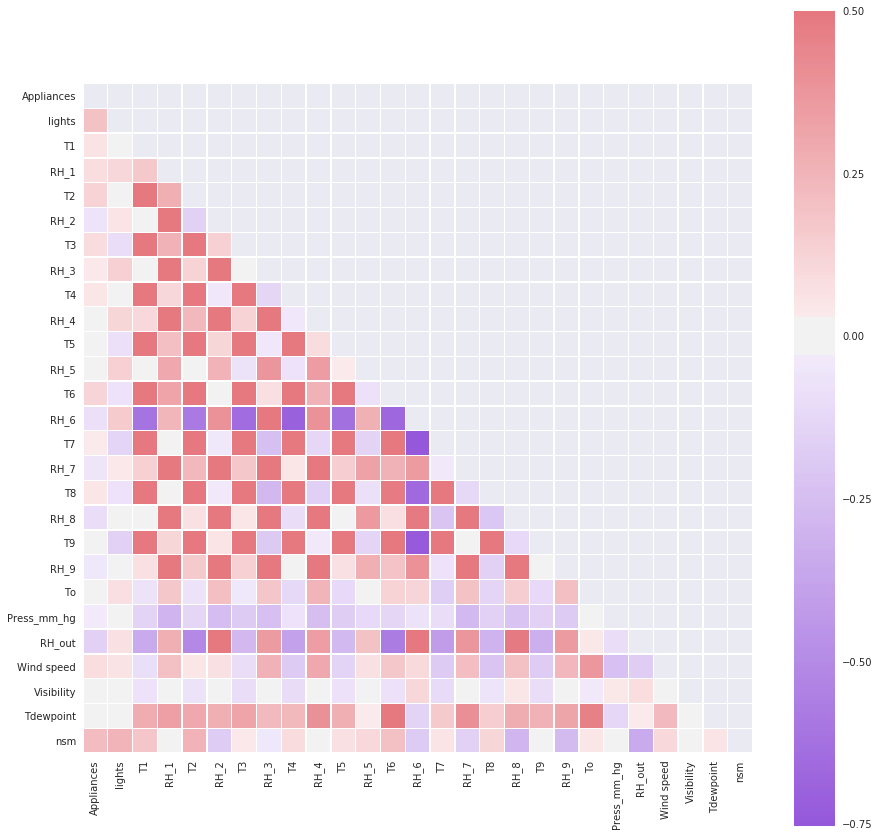

In [31]:
# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))
    
# Generate a custom diverging colormap
cmap = sns.diverging_palette(1000, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 1})

### Model Building - Regression 

 Using the processed dataframe from above steps (using vector assembler,String Indexer, Onehot encoder ) - Numeric variables & Categorical variable , build a spark ml regression model.You are free to build any model of your choice.Metric to evaluate model performance is <font color='green'>RMSE</font>. Build the model on training dataset. Predict the results on test data set . 
<font color='brown'>Note :</font> Training and testdataset have provided separately. Dont split the data into testing and training dataset. 

In [32]:
energyDF = energyDF.drop('date')
testDF = testDF.drop('date')

In [33]:
num_Var_Names = ['lights', 'T1', 'RH_1', 'T2', 'RH_2','T3', 'RH_3', 'T4', 'RH_4', 'T5',
                    'RH_5', 'T6', 'RH_6',"T7","RH_7","T8","RH_8","T9","RH_9","To","Press_mm_hg","RH_out",
                    "Wind speed","Visibility","Tdewpoint","nsm"]

cat_Var_Names = ["weekstatus","Day_of_week"] 

In [34]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

vector_assembler_NumVars = VectorAssembler(inputCols=num_Var_Names, outputCol="num_features_all")
min_Max_Scalar_NumVars = MinMaxScaler(inputCol="num_features_all", outputCol = "scaled_num_features")

In [35]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

indexers_Cat  = [StringIndexer(inputCol=cat_Var_Name, outputCol="{0}_index".format(cat_Var_Name)) for cat_Var_Name in cat_Var_Names ]
encoders_Cat  = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol="{0}_vec".format(indexer.getInputCol())) for indexer in indexers_Cat]
assembler_Cat = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders_Cat], outputCol="cat_features")

assembler     = VectorAssembler(inputCols=["scaled_num_features","cat_features"], outputCol="features")

In [36]:
preprocessiong_Stages = [vector_assembler_NumVars] +\
                        [min_Max_Scalar_NumVars] +\
                        indexers_Cat + encoders_Cat +\
                        [assembler_Cat] +\
                        [assembler]

from pyspark.ml import Pipeline
Pipe_line = Pipeline(stages=preprocessiong_Stages)

In [37]:
splitDF = energyDF.randomSplit([0.7, 0.3], seed=1234) # Split in 70:30
train = splitDF[0]
val = splitDF[1]

In [38]:
from pyspark.ml.regression import LinearRegression # For Regresssion
lr = LinearRegression(maxIter=10, labelCol="Appliances", featuresCol="features")

# Adding to Pipeline
lr_Pipeline = Pipeline(stages=preprocessiong_Stages+[lr])
lr_Pipeline_model = lr_Pipeline.fit(train)

In [39]:
train_predictions_lr = lr_Pipeline_model.transform(train)

In [40]:
test_predictions_lr = lr_Pipeline_model.transform(val)

In [41]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="Appliances",
                            predictionCol="prediction",
                            metricName="rmse" )

lmRegTrain_rmse = evaluator.evaluate(train_predictions_lr) ; print(lmRegTrain_rmse)
lmRegTest_rmse = evaluator.evaluate(test_predictions_lr) ; print(lmRegTest_rmse)

93.0680561453
94.2413757791


In [42]:
# Regression Tuning
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGridLR = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1]) \
    .addGrid(lr.elasticNetParam, [0.5])\
    .addGrid(lr.maxIter, [100])\
    .build()
    
lr_crossval = CrossValidator(estimator=lr_Pipeline,
                             estimatorParamMaps=paramGridLR,
                             evaluator=RegressionEvaluator(labelCol="Appliances"),
                             numFolds=2)

In [43]:
lr_crossval_Model = lr_crossval.fit(train)
train_predictions_lrcv = lr_crossval_Model.transform(train)
test_predictions_lrcv = lr_crossval_Model.transform(val)

In [44]:
predictionAndLabels_train_lrcv = train_predictions_lrcv.select("prediction", "Appliances")
train_accuracycv = evaluator.evaluate(predictionAndLabels_train_lrcv) ; print(train_accuracycv)

predictionAndLabels_test_lrcv = test_predictions_lrcv.select("prediction", "Appliances")
test_accuracycv = evaluator.evaluate(predictionAndLabels_test_lrcv) ; print(test_accuracycv)

93.0840155073
94.2532775808


### Prediction >>> 

In [47]:
lr_crossval_Model.transform(testDF).show()

+------+-----+-----------+----+-----+-----+----+-----+-----------+-----------+-----+-----------+-----------+-----------+-----+----+-----+----+----+----+-----------+------+----------+----------+---------+-----+----------+-----------+--------------------+--------------------+----------------+-----------------+--------------+---------------+-------------------+--------------------+-----------------+
|lights|   T1|       RH_1|  T2| RH_2|   T3|RH_3|   T4|       RH_4|         T5| RH_5|         T6|       RH_6|         T7| RH_7|  T8| RH_8|  T9|RH_9|  To|Press_mm_hg|RH_out|Wind speed|Visibility|Tdewpoint|  nsm|weekstatus|Day_of_week|    num_features_all| scaled_num_features|weekstatus_index|Day_of_week_index|weekstatus_vec|Day_of_week_vec|       cat_features|            features|       prediction|
+------+-----+-----------+----+-----+-----+----+-----+-----------+-----------+-----+-----------+-----------+-----------+-----+----+-----+----+----+----+-----------+------+----------+----------+-------

### ========================================================================================<br/>

#### Classification Model - Problem Statement

**Problem Statement** - Process this data and create machine learning models to predict if a new person is going to experience a financial distress for the next 2 years or not.

**Dataset location** - /user/jayantm/Batch48/PHD 

#### Dataset variables information : 

**Target**,  Person experienced Financial Distress in the past 2 years <br/>
       * 1 - Experienced Financial Distress  
       * 0 - Not experienced any Financial Distress 
**Utilization**, Total balance on credit cards and personal lines of credit divided by the sum of credit limits <br/>
**age**, Age <br/>
**FD_ind1**, Number of times borrower has been in Finanacial distress for 30-59 days <br/>
**Debt Ratio**, Monthly debt payments <br/> 
**Monthly Income**, Monthly income<br/>
**FD_ind2**, Number of Open loans <br/>
**FD_ind3**, Number of times borrower has been 90 days or more past due on repaying <br/>
**FD_ind4**, Number of mortgage and real estate loans including home equity line of credit <br/>
**FD_ind5**, Number of times borrower has been 60-89 days past due but no worse in the last 2 years. <br/>
**NumberOfDependents**, Number of dependents in family excluding themselves <br/>

#### Missing values can be identified with the value, ‘NA’ in the data. Here our target feature name is ‘Target’.

#### move the dataset to HDFS 

In [ ]:
!hdfs dfs -get /user/jayantm/Batch48/PHD/* /home/2306B48/phd/two

In [ ]:
flume-ng agent --conf ./conf -f conf/flume.properties -n agent

#### Construct the schema and Read the dataset from HDFS using Spark as dataframe. Do basic analysis of the data and find how many missing values are there in the dataset and for which features. <br/>
Fill the missing values for features as given below (Do not delete the rows with Null/Missing values):
 Utilization – Fill the average value of this feature for the records having null values for this
feature <br/>
 Age - Fill the average value. <br/>
 FD_ind1 – Take the mode value of this feature and use that to fill null values.<br/>
 DebtRatio – Fill the average value.<br/>
 MonthlyIncome – Fill the average value.<br/>
 NumberOfDependents – Fill with Zero.<br/>
 For rest of the columns consider the mode of the respective feature, while filling out missing
values <br/>

In [48]:
fin = sc.textFile("hdfs:///user/2306B48/phd/two/data/*")

In [49]:
fin.take(2)

[u'1,0.766126609,45,2,0.802982129,9120,13,0,6,0,2',
 u'0,0.957151019,40,0,0.121876201,2600,4,0,0,0,1']

In [50]:
fin.count()

150000

In [51]:
Schema = StructType([
    StructField("Target", IntegerType(), True),
    StructField("Utilization", DoubleType(), True),
    StructField("Age", IntegerType(), True),
    StructField("FD_ind1", IntegerType(), True),
    StructField("DebtRatio", DoubleType(), True),
    StructField("MonthlyIncome", IntegerType(), True),
    StructField("FD_ind2",IntegerType(), True),
    StructField("FD_ind3",IntegerType(), True),
    StructField("FD_ind4",IntegerType(), True),
    StructField("FD_ind5",IntegerType(), True),
    StructField("NumberOfDependents", IntegerType(), True),
])

In [52]:
finDF = spark.read.format("csv")\
        .option("header", "false")\
        .option("inferSchema", "true")\
        .option("nullvalue","NA")\
        .load("hdfs:///user/2306B48/phd/two/data/*",schema = Schema)

In [53]:
finDF.show(5)

+------+-----------+---+-------+-----------+-------------+-------+-------+-------+-------+------------------+
|Target|Utilization|Age|FD_ind1|  DebtRatio|MonthlyIncome|FD_ind2|FD_ind3|FD_ind4|FD_ind5|NumberOfDependents|
+------+-----------+---+-------+-----------+-------------+-------+-------+-------+-------+------------------+
|     1|0.766126609| 45|      2|0.802982129|         9120|     13|      0|      6|      0|                 2|
|     0|0.957151019| 40|      0|0.121876201|         2600|      4|      0|      0|      0|                 1|
|     0| 0.65818014| 38|      1|0.085113375|         3042|      2|      1|      0|      0|                 0|
|     0|0.233809776| 30|      0|0.036049682|         3300|      5|      0|      0|      0|                 0|
|     0|  0.9072394| 49|      1|0.024925695|        63588|      7|      0|      1|      0|                 0|
+------+-----------+---+-------+-----------+-------------+-------+-------+-------+-------+------------------+
only showi

In [54]:
finDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in finDF.columns]).show()

+------+-----------+---+-------+---------+-------------+-------+-------+-------+-------+------------------+
|Target|Utilization|Age|FD_ind1|DebtRatio|MonthlyIncome|FD_ind2|FD_ind3|FD_ind4|FD_ind5|NumberOfDependents|
+------+-----------+---+-------+---------+-------------+-------+-------+-------+-------+------------------+
|     0|          0|  0|      0|        0|        29731|      0|      0|      0|      0|              3924|
+------+-----------+---+-------+---------+-------------+-------+-------+-------+-------+------------------+



In [55]:
finDF.describe("MonthlyIncome").show()  # Mean of monthly Income

+-------+------------------+
|summary|     MonthlyIncome|
+-------+------------------+
|  count|            120269|
|   mean| 6670.221237392844|
| stddev|14384.674215282112|
|    min|                 0|
|    max|           3008750|
+-------+------------------+



In [56]:
fill_cols_vals = {
"NumberOfDependents" : 0 ,
"MonthlyIncome" : 6670 ,   # avg monthly income
}
finDF = finDF.na.fill(fill_cols_vals)

In [57]:
finDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in finDF.columns]).show()

+------+-----------+---+-------+---------+-------------+-------+-------+-------+-------+------------------+
|Target|Utilization|Age|FD_ind1|DebtRatio|MonthlyIncome|FD_ind2|FD_ind3|FD_ind4|FD_ind5|NumberOfDependents|
+------+-----------+---+-------+---------+-------------+-------+-------+-------+-------+------------------+
|     0|          0|  0|      0|        0|            0|      0|      0|      0|      0|                 0|
+------+-----------+---+-------+---------+-------------+-------+-------+-------+-------+------------------+



### Model Building  - Classification

Apply any Spark machie learning technique of your choice and try to see the accuracy of your models. In this case we are trying to find out the person who will experience a financial distress so consider Target atrribute 1 as your positive case and 0 as negative. Experiment with different machine learning models to maximize your recall, Try atleast two different techniques and give the comparison of recall between them.

### Logistic Regression >>>

In [58]:
colnames =["Utilization","Age","FD_ind1","DebtRatio","MonthlyIncome","FD_ind2","FD_ind3",
           "FD_ind4","FD_ind5","NumberOfDependents"]


vector_assembler_NumVars = VectorAssembler(inputCols= colnames, outputCol="num_features_all")
min_Max_Scalar_NumVars = MinMaxScaler(inputCol="num_features_all", outputCol = "scaled_num_features")

In [59]:
indexer_Label = StringIndexer(inputCol="Target", outputCol="label")

In [60]:
preprocessiong_Stages = [vector_assembler_NumVars] +\
                        [min_Max_Scalar_NumVars] +\
                        [indexer_Label]

Pipe_line = Pipeline(stages=preprocessiong_Stages)

In [67]:
splitDF = finDF.randomSplit([0.8, 0.2], seed=100) # Split in 70:30
fin_train = splitDF[0]
fin_test = splitDF[1]

In [68]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=10, labelCol="label", featuresCol="scaled_num_features")

# Adding to Pipeline
lr_Pipeline = Pipeline(stages=preprocessiong_Stages+[lr])
lr_Pipeline_model = lr_Pipeline.fit(fin_train)


# Predicting the output
train_predictions_lr = lr_Pipeline_model.transform(fin_train)
test_predictions_lr = lr_Pipeline_model.transform(fin_test)

#Evaluating the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(metricName="accuracy") # Object Call

predictionAndLabels_train_lr = train_predictions_lr.select("prediction", "label")
train_accuracy_lr = evaluator.evaluate(predictionAndLabels_train_lr) ; train_accuracy_lr # Checking accuracy

0.9325942979163538

In [69]:
predictionAndLabels_test_lr = test_predictions_lr.select("prediction", "label")
test_accuracy_lr = evaluator.evaluate(predictionAndLabels_test_lr) ; test_accuracy_lr # Checking acccuracy

0.9362090721923358

In [70]:
# Tuning the model
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1]) \
    .addGrid(lr.elasticNetParam, [0.5])\
    .build()
    
lr_crossval = CrossValidator(estimator=lr_Pipeline,
                             estimatorParamMaps=paramGrid,
                             evaluator=evaluator,
                             numFolds=2)


# Cross Validation
lr_crossval_Model = lr_crossval.fit(fin_train)

# Predictions
train_predictions_lrcv = lr_crossval_Model.transform(fin_train)
test_predictions_lrcv = lr_crossval_Model.transform(fin_test)

# Accuracy Check
predictionAndLabels_train_lrcv = train_predictions_lrcv.select("prediction", "label")
train_accuracycv = evaluator.evaluate(predictionAndLabels_train_lrcv) ; print(train_accuracycv)

predictionAndLabels_test_lrcv = test_predictions_lrcv.select("prediction", "label")
test_accuracycv = evaluator.evaluate(predictionAndLabels_test_lrcv) ; print(test_accuracycv)

0.932569274144
0.935511722123


In [66]:
# Confusion Matrix
train_pred_pandas = predictionAndLabels_train_lr.toPandas()
train_actuals = train_pred_pandas.label.tolist()
train_predictions = train_pred_pandas.prediction.tolist()

test_pred_pandas = predictionAndLabels_test_lr.toPandas()
test_actuals = test_pred_pandas.label.tolist()
test_predictions = test_pred_pandas.prediction.tolist()
from sklearn import metrics as smetrics
cm = smetrics.confusion_matrix(train_actuals, train_predictions) ; cm

array([[125810,    115],
       [  8910,    134]])

In [76]:
TP = cm[0,0]
TN = cm[0,1]
FP = cm[1,0]
FN = cm[1,1]

In [81]:
true_positive = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 1) & (predictionAndLabels_train_lr.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 0) & (predictionAndLabels_train_lr.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 0) & (predictionAndLabels_train_lr.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_lr[(predictionAndLabels_train_lr.label == 1) & (predictionAndLabels_train_lr.prediction == 0.0)].count()
print "TRAIN METRICS - LINEAR MODEL - BINOMIAL FAMILY"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_lr.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))

TRAIN METRICS - LINEAR MODEL - BINOMIAL FAMILY
True Positives: 112
True Negatives: 111693
False Positives: 109
False Negatives: 7972
Total 119886
Precission:  0.506787330317
Recall:  0.0138545274617
F1 Score:  0.0269717037929


### Decision Tree >>>

In [82]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="scaled_num_features")

# Creating a Pipeline
dt_Pipeline = Pipeline(stages=preprocessiong_Stages+[dt]) 
dt_Pipeline_model = dt_Pipeline.fit(fin_train)

# Predictions
train_predictions_dt = dt_Pipeline_model.transform(fin_train)
test_predictions_dt = dt_Pipeline_model.transform(fin_test)

# Evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictionAndLabels_train_dt = train_predictions_dt.select("prediction", "label")

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
train_accuracy = evaluator.evaluate(predictionAndLabels_train_dt)

predictionAndLabels_test_dt = test_predictions_dt.select("prediction", "label")
test_accuracy = evaluator.evaluate(predictionAndLabels_test_dt)

In [83]:
print(train_accuracy)
print(test_accuracy)

0.936489665182
0.938699608156


In [85]:
true_positive = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 1) & (predictionAndLabels_train_dt.prediction == 1.0)].count()
true_negative = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 0) & (predictionAndLabels_train_dt.prediction == 0.0)].count()
false_positive = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 0) & (predictionAndLabels_train_dt.prediction == 1.0)].count()
false_negative = predictionAndLabels_train_dt[(predictionAndLabels_train_dt.label == 1) & (predictionAndLabels_train_dt.prediction == 0.0)].count()
print "TRAIN METRICS - LINEAR MODEL - BINOMIAL FAMILY"
print "True Positives:", true_positive
print "True Negatives:", true_negative
print "False Positives:", false_positive
print "False Negatives:", false_negative
print "Total", predictionAndLabels_train_dt.count()
precission = true_positive / float(true_positive + false_positive)
print "Precission: ", precission
recall = true_positive / float(true_positive + false_negative)
print "Recall: ", recall
print "F1 Score: ", (2*((precission * recall)/float(precission + recall)))

TRAIN METRICS - LINEAR MODEL - BINOMIAL FAMILY
True Positives: 1478
True Negatives: 110794
False Positives: 1008
False Negatives: 6606
Total 119886
Precission:  0.594529364441
Recall:  0.182830282039
F1 Score:  0.279659413434
